--- Processing model: Paccmann_MCA, study: gCSI ---
{'best': ['./Paccmann_MCA/gCSI/MEDIUM/best-18.json'], 'log': ['./Paccmann_MCA/gCSI/MEDIUM/deap-18.log'], 'fitnesses': ['./Paccmann_MCA/gCSI/MEDIUM/fitnesses-18.txt'], 'fitness': ['./Paccmann_MCA/gCSI/MEDIUM/fitness-18.txt'], 'hyperparams': ['./Paccmann_MCA/gCSI/MEDIUM/hyperparams.Paccmann_MCA.gCSI.medium.json'], 'cfg': ['./Paccmann_MCA/gCSI/MEDIUM/cfg-Paccmann_MCA-gCSI-medium.sh'], 'hpo': ['./Paccmann_MCA/gCSI/MEDIUM/hpo.csv']}
--- Processing model: Paccmann_MCA, study: CCLE ---
{'best': ['./Paccmann_MCA/CCLE/MEDIUM/best-24.json'], 'log': ['./Paccmann_MCA/CCLE/MEDIUM/deap-24.log'], 'fitnesses': ['./Paccmann_MCA/CCLE/MEDIUM/fitnesses-24.txt'], 'fitness': ['./Paccmann_MCA/CCLE/MEDIUM/fitness-24.txt'], 'hyperparams': ['./Paccmann_MCA/CCLE/MEDIUM/hyperparams.Paccmann_MCA.CCLE.medium.json'], 'cfg': ['./Paccmann_MCA/CCLE/MEDIUM/cfg-Paccmann_MCA-CCLE-medium.sh'], 'hpo': ['./Paccmann_MCA/CCLE/MEDIUM/hpo.csv']}
--- Processing model: GraphDRP, 

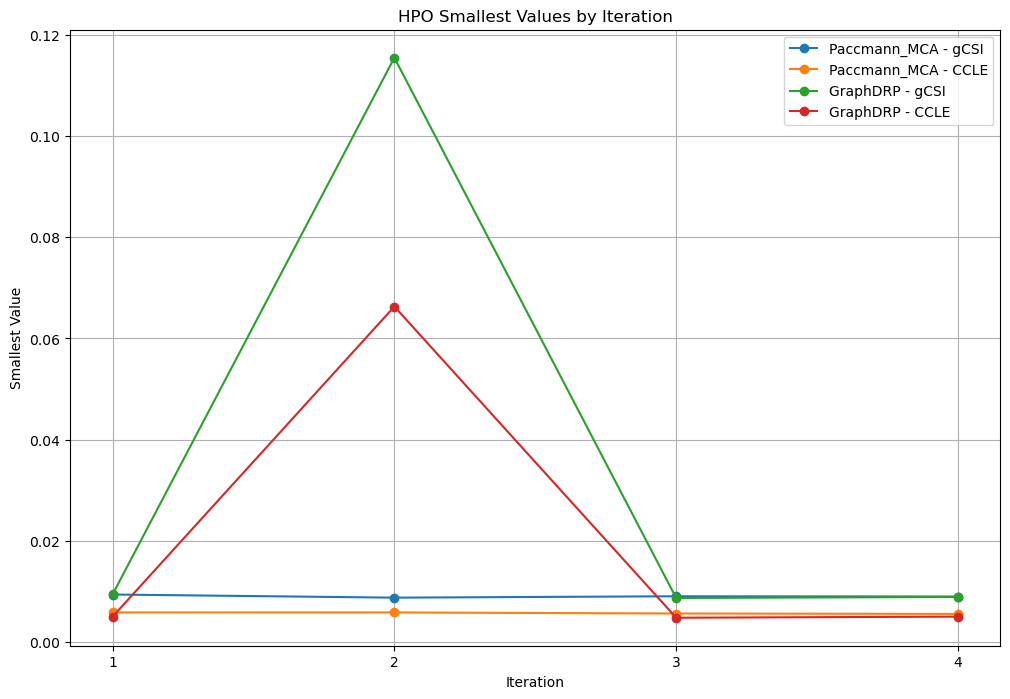

In [8]:
import json
import csv
import os
import glob
import matplotlib.pyplot as plt

def read_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def read_log(file_path):
    with open(file_path, 'r') as file:
        return file.readlines()

def read_text(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def read_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        return [row for row in reader]

def parse_files(base_dir, model, study, size):
    directory = os.path.join(base_dir, f"{model}", study, size.upper())
    files = {
        "best": glob.glob(os.path.join(directory, "best-*.json")),
        "log": glob.glob(os.path.join(directory, "deap-*.log")),
        "fitnesses": glob.glob(os.path.join(directory, "fitnesses-*.txt")),
        "fitness": glob.glob(os.path.join(directory, "fitness-*.txt")),
        "hyperparams": glob.glob(os.path.join(directory, "*param*.json")),
        "cfg": glob.glob(os.path.join(directory, "cfg-*.sh")),
        "hpo": [os.path.join(directory, "hpo.csv")]
    }
    print(files)
    data = {}
    
    data['best'] = [read_json(file) for file in files['best']]
    data['log'] = [read_log(file) for file in files['log']]
    data['fitnesses'] = [read_text(file) for file in files['fitnesses']]
    data['fitness'] = [read_text(file) for file in files['fitness']]
    data['hyperparams'] = [read_json(file) for file in files['hyperparams']]
    data['cfg'] = [read_text(file) for file in files['cfg']]
    data['hpo'] = [read_csv(file) for file in files['hpo']]
    
    return data

def extract_smallest_values(hpo_data):
    iteration_to_smallest_value = {}
    
    for row in hpo_data[1:]:  # Skipping header row
        iteration = int(row[0])
        result = float(row[6])  # Assuming 'result' is the 7th column
        if iteration not in iteration_to_smallest_value:
            iteration_to_smallest_value[iteration] = result
        else:
            if result < iteration_to_smallest_value[iteration]:
                iteration_to_smallest_value[iteration] = result
    
    iterations = sorted(iteration_to_smallest_value.keys())
    smallest_values = [iteration_to_smallest_value[iteration] for iteration in iterations]
    
    return iterations, smallest_values

if __name__ == "__main__":
    base_dir = "."
    models = ["Paccmann_MCA", "GraphDRP"]
    studies = ["gCSI", "CCLE"]
    size = "medium"
    
    all_data = []

    plt.figure(figsize=(12, 8))
    
    for model in models:
        for study in studies:
            print(f"--- Processing model: {model}, study: {study} ---")
            data = parse_files(base_dir, model, study, size)
            all_data.append(data)
            
            hpo_data = data['hpo'][0]
            iterations, smallest_values = extract_smallest_values(hpo_data)
            
            label = f"{model} - {study}"
            plt.plot(iterations, smallest_values, marker='o', label=label)
    
    plt.xlabel('Iteration')
    plt.ylabel('Smallest Value')
    plt.title('HPO Smallest Values by Iteration')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis ticks to be integers
    max_iteration = max([max(data[0]) for data in [extract_smallest_values(d['hpo'][0]) for d in all_data]])
    plt.xticks(range(1, max_iteration + 1))
    
    plt.show()
